In [87]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib as mp
import matplotlib.pyplot as plt

## cells

In [88]:
import pandas as pd
import os

methods = [
    'velocyto', 'scvelo_dyn', 'scvelo_stc', 'veloae', 'dynamo_m1','velovae_std','velovae_fullvb',
    'unitvelo_ind', 'unitvelo_uni', 'deepvelo', 'celldancer',
    'pyrovelocity_m1', 'pyrovelocity_m2', 'kvelo', 'velovi', 'sdevelo',
    'cell2fate', 'svelvetvae', 'latentvelo_std', 'tivelo_std', 'tivelo_simple',
    'sctour_mse', 'sctour_nb', 'sctour_zinb', 'graphvelo_std'
]

target_cells = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]

all_data_list = []

In [89]:
for method in methods:
    file_name = f'cells/{method}_cell_results.csv'
    base_df = pd.DataFrame({'cells': target_cells})
    
    if os.path.exists(file_name):
        try:
            df = pd.read_csv(file_name)
            df_success = df[df['status'] == 'success'].copy().reset_index(drop=True)
            merged_df = pd.merge(base_df, df_success, on='cells', how='left')
        except Exception:
            merged_df = base_df.copy()
    else:
        merged_df = base_df.copy()
    
    merged_df['method'] = method
    
    # 补齐必要列
    for col in ['execution_time_sec', 'peak_memory_mb']:
        if col not in merged_df.columns:
            merged_df[col] = np.nan
            
    all_data_list.append(merged_df[['method', 'cells', 'execution_time_sec', 'peak_memory_mb']])

full_df = pd.concat(all_data_list, ignore_index=True)

In [90]:
def inverted_min_max_normalize(x):
    if x.isnull().all(): 
        return x
    if x.max() == x.min(): 
        return 1.0
    return 1 - (x - x.min()) / (x.max() - x.min())

full_df['score_time'] = full_df.groupby('cells')['execution_time_sec'].transform(inverted_min_max_normalize)
full_df['score_memory'] = full_df.groupby('cells')['peak_memory_mb'].transform(inverted_min_max_normalize)

full_df['score_avg'] = (full_df['score_time'] + full_df['score_memory']) / 2


full_df['rank'] = full_df.groupby('cells')['score_avg'].rank(method='min', ascending=False, na_option='keep')

In [91]:
overall_stats = []

def get_capacity_score(max_cells):
    if max_cells >= 1000000: return 4
    if max_cells >= 500000: return 3
    if max_cells >= 100000: return 2
    if max_cells >= 50000: return 1
    if max_cells >= 10000: return 0
    return 0

In [92]:
for method in methods:
    valid_runs = full_df[(full_df['method'] == method) & (full_df['execution_time_sec'].notna())]
    
    if len(valid_runs) > 0:
        max_capacity = valid_runs['cells'].max()
        capacity_base = get_capacity_score(max_capacity)
        
        target_run = valid_runs[valid_runs['cells'] == max_capacity]
        
        if not target_run.empty:
            efficiency_bonus = target_run['score_avg'].values[0]
        else:
            efficiency_bonus = 0.0
        
        scalability_score = capacity_base + efficiency_bonus
        
    else:
        max_capacity = 0
        capacity_base = 0
        efficiency_bonus = 0.0
        scalability_score = 0.0
    
    overall_stats.append({
        'method': method,
        'max_capacity': max_capacity,
        'capacity_base': capacity_base,
        'efficiency_bonus': efficiency_bonus,
        'scalability_score': scalability_score
    })

In [93]:
summary_df = pd.DataFrame(overall_stats)

summary_df = summary_df.sort_values(by='scalability_score', ascending=False)

summary_df['overall_rank'] = range(1, len(summary_df) + 1)

In [94]:
detailed_view = full_df.sort_values(by=['cells', 'rank'])

In [95]:
summary_df
summary_df.to_csv(f'cell_scalability_summary.csv', index=False)

In [96]:
pivot_df = full_df.pivot(index='method', columns='cells', values='rank')
final_matrix = pd.merge(full_df, summary_df[['method', 'overall_rank']], on='method', how='left')
print(final_matrix.head().to_string())

     method   cells  execution_time_sec  peak_memory_mb  score_time  score_memory  score_avg  rank  overall_rank
0  velocyto    1000            4.621517       89.032219         1.0      0.981294   0.990647   1.0             4
1  velocyto    5000            5.053940      432.799814         1.0      0.880325   0.940162   1.0             4
2  velocyto   10000            6.074821      860.672012         1.0      0.906460   0.953230   1.0             4
3  velocyto   50000           14.422813     4289.076244         1.0      0.934068   0.967034   5.0             4
4  velocyto  100000           16.798615     8570.102852         1.0      0.863647   0.931824   6.0             4


Visualization finished.


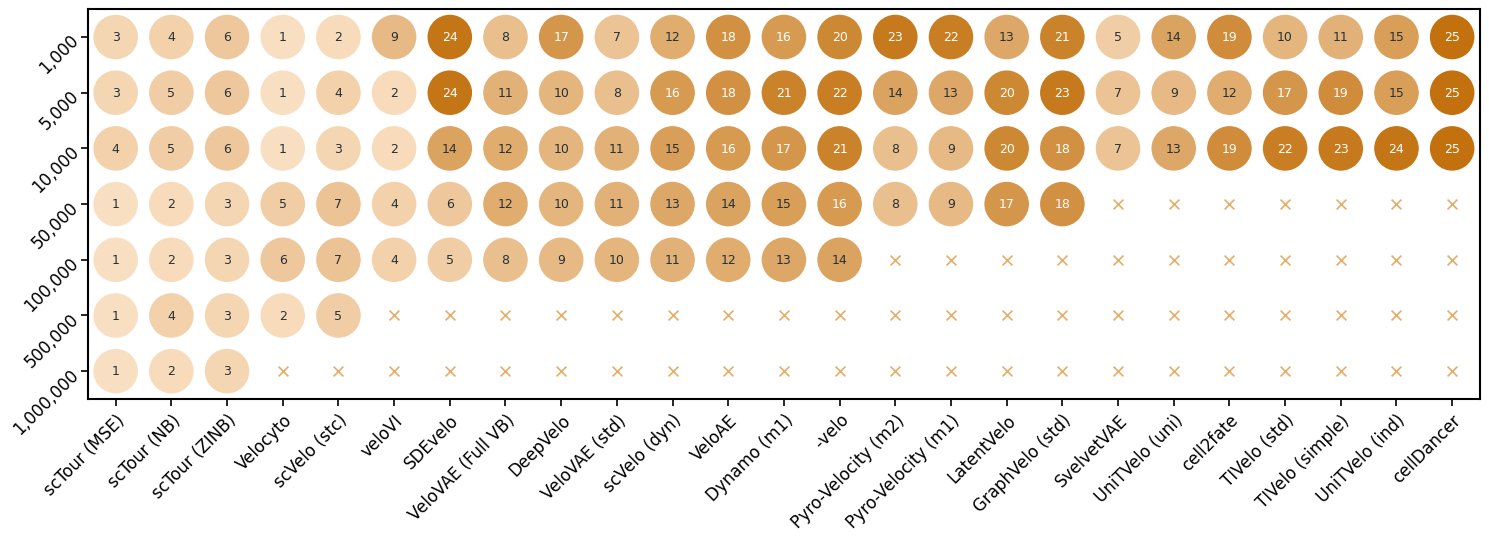

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import pandas as pd
import numpy as np

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

FONT_SIZE_METHODS = 12
FONT_SIZE_CELLS = 12
FONT_SIZE_RANK = 9

COLOR_START = "#f9dfc1"
COLOR_END = "#c2710e"

BOX_EDGE_COLOR = '#CFD8DC'
BOX_LINE_WIDTH = 0
OUTER_BORDER_COLOR = 'black'
OUTER_BORDER_WIDTH = 1.5
CIRCLE_RADIUS = 0.40

FAIL_ICON = 'x'
FAIL_COLOR = "#e5ad67"
FAIL_SIZE = 50
FAIL_LINEWIDTH = 1.2

FIGURE_WIDTH = 15
FIGURE_HEIGHT = 5.5

newmethods = {
    'unitvelo_ind': 'UniTVelo (ind)',
    'velovi': 'veloVI',
    'cell2fate': 'cell2fate',
    'latentvelo_std': 'LatentVelo',
    'pyrovelocity_m1': 'Pyro-Velocity (m1)',
    'pyrovelocity_m2': 'Pyro-Velocity (m2)',
    'sctour_mse': 'scTour (MSE)',
    'sctour_nb': 'scTour (NB)',
    'sctour_zinb': 'scTour (ZINB)',
    'scvelo_dyn': 'scVelo (dyn)',
    'unitvelo_uni': 'UniTVelo (uni)',
    'deepvelo': 'DeepVelo',
    'svelvetvae': 'SvelvetVAE',
    'tivelo_std': 'TIVelo (std)',
    'tivelo_simple': 'TIVelo (simple)',
    'velocyto': 'Velocyto',
    'veloae': 'VeloAE',
    'velovae_std': 'VeloVAE (std)',
    'velovae_fullvb': 'VeloVAE (Full VB)',
    'kvelo': '  -velo',
    'celldancer': 'cellDancer',
    'dynamo_m1': 'Dynamo (m1)',
    'graphvelo_std': 'GraphVelo (std)',
    'scvelo_stc': 'scVelo (stc)',
    'sdevelo': 'SDEvelo'
}

target_cells_raw = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
cell_labels_formatted = [f"{x:,}" for x in target_cells_raw]

plot_df = final_matrix.copy()

if 'overall_rank' in plot_df.columns:
    method_order = plot_df.sort_values('overall_rank', ascending=True)['method'].unique()
else:
    method_order = plot_df['method'].unique()

heatmap_data = plot_df.pivot(index='method', columns='cells', values='rank')
heatmap_data = heatmap_data.reindex(method_order)

if newmethods:
    heatmap_data.rename(index=newmethods, inplace=True)

heatmap_data = heatmap_data.T

valid_cells = [c for c in target_cells_raw if c in heatmap_data.index]
heatmap_data = heatmap_data.reindex(valid_cells)
cell_labels_formatted = [f"{x:,}" for x in valid_cells]

cmap = mcolors.LinearSegmentedColormap.from_list(
    "journal_gradient", [COLOR_START, COLOR_END]
)
norm = mcolors.Normalize(
    vmin=heatmap_data.min().min(),
    vmax=heatmap_data.max().max()
)

def get_text_color(val, vmin, vmax):
    threshold = vmin + (vmax - vmin) * 0.6
    return 'white' if val > threshold else '#263238'

fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

sns.heatmap(
    heatmap_data,
    fmt='',
    cbar=False,
    xticklabels=True,
    yticklabels=cell_labels_formatted,
    alpha=0,
    ax=ax
)

ax.set_aspect('equal')

nrows, ncols = heatmap_data.shape
vmin, vmax = heatmap_data.min().min(), heatmap_data.max().max()

for i in range(nrows):
    for j in range(ncols):
        val = heatmap_data.iloc[i, j]
        center_x, center_y = j + 0.5, i + 0.5

        if pd.notnull(val):
            face_color = cmap(norm(val))
            circle = patches.Circle(
                (center_x, center_y),
                radius=CIRCLE_RADIUS,
                ec=BOX_EDGE_COLOR,
                linewidth=BOX_LINE_WIDTH,
                fc=face_color
            )
            ax.add_patch(circle)

            text_color = get_text_color(val, vmin, vmax)
            ax.text(
                center_x, center_y, f"{int(val)}",
                ha='center', va='center',
                color=text_color,
                fontsize=FONT_SIZE_RANK,
                fontweight='medium'
            )
        else:
            ax.scatter(
                center_x, center_y,
                s=FAIL_SIZE,
                color=FAIL_COLOR,
                marker=FAIL_ICON,
                linewidth=FAIL_LINEWIDTH,
                zorder=10
            )

plt.title("")
plt.xlabel("")
plt.ylabel("")

plt.setp(
    ax.get_xticklabels(),
    rotation=45, ha="right", rotation_mode="anchor"
)

ax.tick_params(
    axis='x', which='major', direction='out',
    length=5, width=1.2, colors=OUTER_BORDER_COLOR,
    top=False, bottom=True,
    labelsize=FONT_SIZE_METHODS
)

plt.setp(
    ax.get_yticklabels(),
    rotation=45, ha="right", rotation_mode="anchor"
)

ax.tick_params(
    axis='y', which='major', direction='out',
    length=5, width=1.2, colors=OUTER_BORDER_COLOR,
    left=True, right=False,
    labelsize=FONT_SIZE_CELLS
)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(OUTER_BORDER_WIDTH)
    spine.set_color(OUTER_BORDER_COLOR)

plt.tight_layout()

ax.set_facecolor('white')
fig.patch.set_facecolor('white')

plt.savefig(
    'cell_scalability.svg',
    dpi=300,
    bbox_inches='tight'
)

print("Visualization finished.")
plt.show()


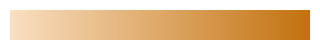

In [98]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(3, 0.3))

morandi_viridis_list = [
    "#f9dfc1",
    "#c2710e",
]
cmap = mcolors.LinearSegmentedColormap.from_list(
    "morandi_viridis_r", morandi_viridis_list
)

norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')

cbar.ax.set_xticks([])
cbar.ax.set_yticks([])
cbar.ax.tick_params(
    bottom=False, top=False, labelbottom=False, labeltop=False,
    left=False, right=False, labelleft=False, labelright=False
)

for spine in cbar.ax.spines.values():
    spine.set_visible(False)

cbar.ax.set_facecolor('none')

cbar.set_label('')

plt.tight_layout(pad=0)

plt.savefig(
    f"colorbar_cell.png",
    bbox_inches='tight',
    pad_inches=0,
    transparent=True,
    facecolor='none'
)

## genes

In [99]:
import pandas as pd
import os

methods = [
    'velocyto', 'scvelo_dyn', 'scvelo_stc', 'veloae', 'dynamo_m1','velovae_std','velovae_fullvb',
    'unitvelo_ind', 'unitvelo_uni', 'deepvelo', 'celldancer',
    'pyrovelocity_m1', 'pyrovelocity_m2', 'kvelo', 'velovi', 'sdevelo',
    'cell2fate', 'svelvetvae', 'latentvelo_std', 'tivelo_std', 'tivelo_simple',
    'sctour_mse', 'sctour_nb', 'sctour_zinb', 'graphvelo_std'
]

target_genes = [1000, 2000, 5000, 10000, 15000, 20000]

all_data_list = []

In [100]:
for method in methods:
    file_name = f'genes/{method}_gene_results.csv'
    base_df = pd.DataFrame({'genes': target_genes})
    
    if os.path.exists(file_name):
        try:
            df = pd.read_csv(file_name)
            df_success = df[df['status'] == 'success'].copy().reset_index(drop=True)
            merged_df = pd.merge(base_df, df_success, on='genes', how='left')
        except Exception:
            merged_df = base_df.copy()
    else:
        merged_df = base_df.copy()
    
    merged_df['method'] = method
    
    for col in ['execution_time_sec', 'peak_memory_mb']:
        if col not in merged_df.columns:
            merged_df[col] = np.nan
            
    all_data_list.append(merged_df[['method', 'genes', 'execution_time_sec', 'peak_memory_mb']])

full_df = pd.concat(all_data_list, ignore_index=True)

In [101]:
def inverted_min_max_normalize(x):
    if x.isnull().all(): 
        return x
    if x.max() == x.min(): 
        return 1.0
    return 1 - (x - x.min()) / (x.max() - x.min())

full_df['score_time'] = full_df.groupby('genes')['execution_time_sec'].transform(inverted_min_max_normalize)
full_df['score_memory'] = full_df.groupby('genes')['peak_memory_mb'].transform(inverted_min_max_normalize)

full_df['score_avg'] = (full_df['score_time'] + full_df['score_memory']) / 2

full_df['rank'] = full_df.groupby('genes')['score_avg'].rank(method='min', ascending=False, na_option='keep')

In [102]:
overall_stats = []

def get_capacity_score(max_genes):
    if max_genes >= 20000: return 4
    if max_genes >= 15000: return 3
    if max_genes >= 10000: return 2
    if max_genes >= 5000: return 1
    if max_genes >= 2000: return 0
    return 0

In [103]:
for method in methods:
    valid_runs = full_df[(full_df['method'] == method) & (full_df['execution_time_sec'].notna())]
    
    if len(valid_runs) > 0:
        max_capacity = valid_runs['genes'].max()
        capacity_base = get_capacity_score(max_capacity)
        
        target_run = valid_runs[valid_runs['genes'] == max_capacity]
        
        if not target_run.empty:
            efficiency_bonus = target_run['score_avg'].values[0]
        else:
            efficiency_bonus = 0.0
        
        scalability_score = capacity_base + efficiency_bonus
        
    else:
        max_capacity = 0
        capacity_base = 0
        efficiency_bonus = 0.0
        scalability_score = 0.0
    
    overall_stats.append({
        'method': method,
        'max_capacity': max_capacity,
        'capacity_base': capacity_base,
        'efficiency_bonus': efficiency_bonus,
        'scalability_score': scalability_score
    })

In [104]:
summary_df = pd.DataFrame(overall_stats)

summary_df = summary_df.sort_values(by='scalability_score', ascending=False)

summary_df['overall_rank'] = range(1, len(summary_df) + 1)

In [105]:
detailed_view = full_df.sort_values(by=['genes', 'rank'])

In [106]:
summary_df
summary_df.to_csv(f'gene_scalability_summary.csv', index=False)

In [107]:
pivot_df = full_df.pivot(index='method', columns='genes', values='rank')
final_matrix = pd.merge(full_df, summary_df[['method', 'overall_rank']], on='method', how='left')
print(final_matrix.head().to_string())

     method  genes  execution_time_sec  peak_memory_mb  score_time  score_memory  score_avg  rank  overall_rank
0  velocyto   1000            6.074821      860.672012         1.0      0.906460   0.953230   1.0             8
1  velocyto   2000            4.788929     1711.527656         1.0      0.876945   0.938473   5.0             8
2  velocyto   5000            8.850691     4263.878692         1.0      0.874879   0.937440   6.0             8
3  velocyto  10000           18.833370     8518.029299         1.0      0.792703   0.896351  10.0             8
4  velocyto  15000           25.361610    12772.195570         1.0      0.792534   0.896267   6.0             8


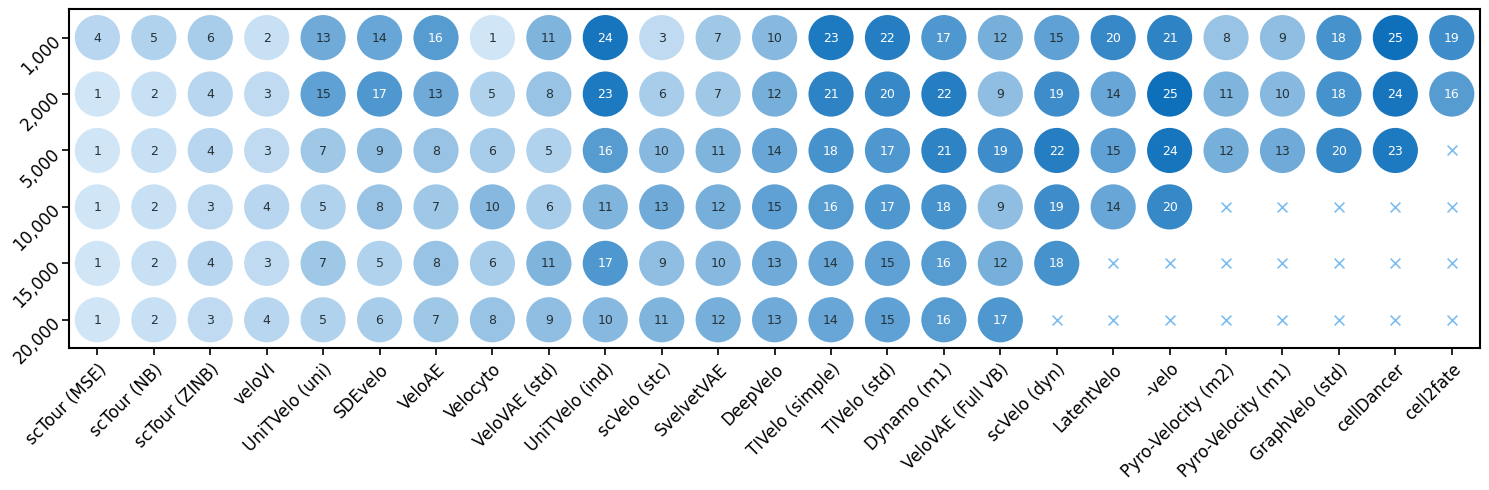

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import pandas as pd
import numpy as np

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

FONT_SIZE_METHODS = 12
FONT_SIZE_GENES = 12
FONT_SIZE_RANK = 9

COLOR_START = "#d0e5f6"
COLOR_END = "#0e70bb"

BOX_EDGE_COLOR = '#CFD8DC'
BOX_LINE_WIDTH = 0
OUTER_BORDER_COLOR = 'black'
OUTER_BORDER_WIDTH = 1.5
CIRCLE_RADIUS = 0.40

FAIL_ICON = 'x'
FAIL_COLOR = "#7ebded"
FAIL_SIZE = 50
FAIL_LINEWIDTH = 1.2

FIGURE_WIDTH = 15
FIGURE_HEIGHT = 5.5

newmethods = {
    'unitvelo_ind': 'UniTVelo (ind)',
    'velovi': 'veloVI',
    'cell2fate': 'cell2fate',
    'latentvelo_std': 'LatentVelo',
    'pyrovelocity_m1': 'Pyro-Velocity (m1)',
    'pyrovelocity_m2': 'Pyro-Velocity (m2)',
    'sctour_mse': 'scTour (MSE)',
    'sctour_nb': 'scTour (NB)',
    'sctour_zinb': 'scTour (ZINB)',
    'scvelo_dyn': 'scVelo (dyn)',
    'unitvelo_uni': 'UniTVelo (uni)',
    'deepvelo': 'DeepVelo',
    'svelvetvae': 'SvelvetVAE',
    'tivelo_std': 'TIVelo (std)',
    'tivelo_simple': 'TIVelo (simple)',
    'velocyto': 'Velocyto',
    'veloae': 'VeloAE',
    'velovae_std': 'VeloVAE (std)',
    'velovae_fullvb': 'VeloVAE (Full VB)',
    'kvelo': '  -velo',
    'celldancer': 'cellDancer',
    'dynamo_m1': 'Dynamo (m1)',
    'graphvelo_std': 'GraphVelo (std)',
    'scvelo_stc': 'scVelo (stc)',
    'sdevelo': 'SDEvelo'
}

target_genes_raw = [1000, 2000, 5000, 10000, 15000, 20000]
gene_labels_formatted = [f"{x:,}" for x in target_genes_raw]

plot_df = final_matrix.copy()

if 'overall_rank' in plot_df.columns:
    method_order = plot_df.sort_values('overall_rank', ascending=True)['method'].unique()
else:
    method_order = plot_df['method'].unique()

heatmap_data = plot_df.pivot(index='method', columns='genes', values='rank')
heatmap_data = heatmap_data.reindex(method_order)

if newmethods:
    heatmap_data.rename(index=newmethods, inplace=True)

heatmap_data = heatmap_data.T

valid_genes = [c for c in target_genes_raw if c in heatmap_data.index]
heatmap_data = heatmap_data.reindex(valid_genes)
gene_labels_formatted = [f"{x:,}" for x in valid_genes]

cmap = mcolors.LinearSegmentedColormap.from_list(
    "journal_gradient", [COLOR_START, COLOR_END]
)
norm = mcolors.Normalize(
    vmin=heatmap_data.min().min(),
    vmax=heatmap_data.max().max()
)

def get_text_color(val, vmin, vmax):
    threshold = vmin + (vmax - vmin) * 0.6
    return 'white' if val > threshold else '#263238'

fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

sns.heatmap(
    heatmap_data,
    fmt='',
    cbar=False,
    xticklabels=True,
    yticklabels=gene_labels_formatted,
    alpha=0,
    ax=ax
)

ax.set_aspect('equal')

nrows, ncols = heatmap_data.shape
vmin, vmax = heatmap_data.min().min(), heatmap_data.max().max()

for i in range(nrows):
    for j in range(ncols):
        val = heatmap_data.iloc[i, j]
        center_x, center_y = j + 0.5, i + 0.5

        if pd.notnull(val):
            face_color = cmap(norm(val))
            circle = patches.Circle(
                (center_x, center_y),
                radius=CIRCLE_RADIUS,
                ec=BOX_EDGE_COLOR,
                linewidth=BOX_LINE_WIDTH,
                fc=face_color
            )
            ax.add_patch(circle)

            text_color = get_text_color(val, vmin, vmax)
            ax.text(
                center_x, center_y, f"{int(val)}",
                ha='center', va='center',
                color=text_color,
                fontsize=FONT_SIZE_RANK,
                fontweight='medium'
            )
        else:
            ax.scatter(
                center_x, center_y,
                s=FAIL_SIZE,
                color=FAIL_COLOR,
                marker=FAIL_ICON,
                linewidth=FAIL_LINEWIDTH,
                zorder=10
            )

plt.title("")
plt.xlabel("")
plt.ylabel("")

plt.setp(
    ax.get_xticklabels(),
    rotation=45, ha="right", rotation_mode="anchor"
)

ax.tick_params(
    axis='x', which='major', direction='out',
    length=5, width=1.2, colors=OUTER_BORDER_COLOR,
    top=False, bottom=True,
    labelsize=FONT_SIZE_METHODS
)

plt.setp(
    ax.get_yticklabels(),
    rotation=45, ha="right", rotation_mode="anchor"
)

ax.tick_params(
    axis='y', which='major', direction='out',
    length=5, width=1.2, colors=OUTER_BORDER_COLOR,
    left=True, right=False,
    labelsize=FONT_SIZE_GENES
)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(OUTER_BORDER_WIDTH)
    spine.set_color(OUTER_BORDER_COLOR)

plt.tight_layout()

ax.set_facecolor('white')
fig.patch.set_facecolor('white')

plt.savefig(
    'genes_calability.svg',
    dpi=300,
    bbox_inches='tight'
)

plt.show()


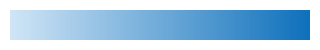

In [109]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(3, 0.3))

morandi_viridis_list = [
    "#d0e5f6",
    "#0e70bb",
]
cmap = mcolors.LinearSegmentedColormap.from_list(
    "morandi_viridis_r", morandi_viridis_list
)

norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')

cbar.ax.set_xticks([])
cbar.ax.set_yticks([])
cbar.ax.tick_params(
    bottom=False, top=False, labelbottom=False, labeltop=False,
    left=False, right=False, labelleft=False, labelright=False
)

for spine in cbar.ax.spines.values():
    spine.set_visible(False)

cbar.ax.set_facecolor('none')

cbar.set_label('')

plt.tight_layout(pad=0)

plt.savefig(
    "colorbar_gene.png",
    bbox_inches='tight',
    pad_inches=0,
    transparent=True,
    facecolor='none'
)


## Real data

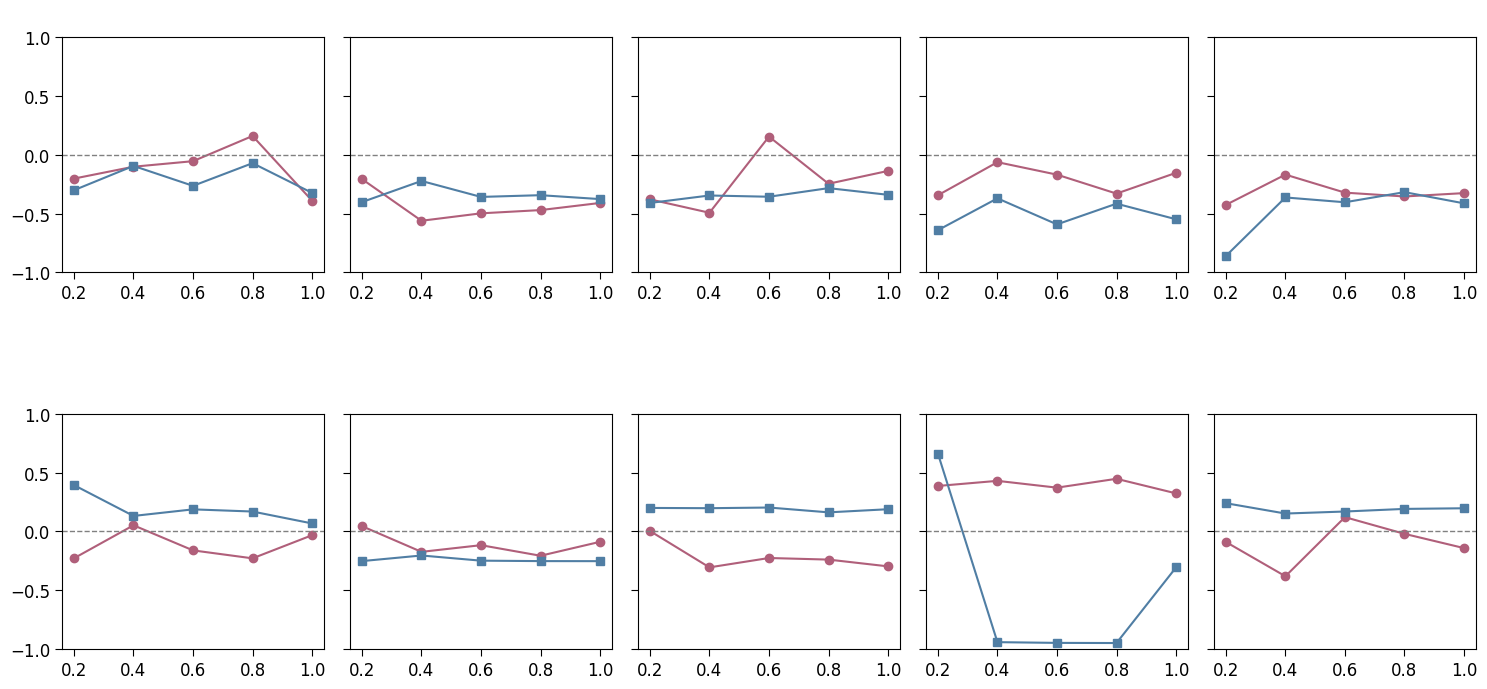

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


select_methods = [
    'sctour_mse', 'sctour_nb', 'sctour_zinb',
    'velocyto', 'scvelo_stc',
    'velovi', 'sdevelo',
    'velovae_fullvb', 'deepvelo', 'velovae_std'
]

downsample_levels = np.array([0.2, 0.4, 0.6, 0.8, 1.0])
value_cols = ['0', '1', '2', '3', '4']

cbdir_color = "#b05f7a"
spearman_color = "#507ea4"

y_ticks = [-1.0, -0.5, 0.0, 0.5, 1.0]


cbdir_df = pd.read_csv("data2/cbdir_df.csv")
spearman_df = pd.read_csv("data12/spearman_df.csv")

for df in (cbdir_df, spearman_df):
    df["Method"] = pd.Categorical(
        df["Method"],
        categories=select_methods,
        ordered=True
    )

cbdir_df = cbdir_df.sort_values("Method")
spearman_df = spearman_df.sort_values("Method")

fig, axes = plt.subplots(
    2, 5,
    figsize=(15, 7),
    sharey='row'
)

for i, method in enumerate(select_methods):
    ax = axes[i // 5, i % 5]

    cbdir_vals = cbdir_df.loc[
        cbdir_df["Method"] == method, value_cols
    ].values[0].astype(float)

    spearman_vals = spearman_df.loc[
        spearman_df["Method"] == method, value_cols
    ].values[0].astype(float)

    ax.plot(downsample_levels, cbdir_vals,
            marker='o', linewidth=1.5, color=cbdir_color)
    ax.plot(downsample_levels, spearman_vals,
            marker='s', linewidth=1.5, color=spearman_color)

    ax.set_ylim(-1, 1)
    ax.set_yticks(y_ticks)
    ax.axhline(0, linestyle='--', linewidth=1, color='gray')

    ax.set_title(" ", pad=10)

    ax.set_xticks(downsample_levels)
    ax.tick_params(axis='x', labelbottom=True, length=5, labelsize=12)

    if i in (0, 5):
        ax.tick_params(axis='y', labelleft=True, length=5, labelsize=12)
    else:
        ax.tick_params(axis='y', labelleft=False, length=5)

plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.savefig('scalability_top10.svg', format='svg', bbox_inches='tight')

plt.show()
